# Introduction to mm-wave TES Bolometers

# Power Balance
Our bolometers work by absorbing optical (millimeter-wave) power onto a thermally isolated "island", which heats above the base-temperature substrate, as shown in the figure below.

<img src="BoloIntro/Bolometer.png"  width="600"/>

The bolometer absorbs optical power $P_{optical}$, and the resistive temperature sensor also deposits $P_{elec} = V^2/R_{bolo}$ onto the island.  The temperature of the bolometer island ($T_{bolo}$) rises above the temperature of the thermal bath ($T_{bath}$) until the power deposited on the island matches the power leaking out through the thermal link, 

$$ P_{total} = P_{optical} + P_{elec} = \bar{G} (T_{bolo} - T_{bath}) .$$

The quantity $\bar{G}$ is the average thermal conductance;  we will later meet a related quantity, the dynamic thermal conductance $G_{dyn}$.  It is good to know that both exist, and that various experts confusingly refer to one or the other as $G$.  In most of the literature, you'll find an unsubscripted $G$ refers to $G_{dyn}$, but it pays to be careful.


The general idea behind a bolometer is that one uses a temperature sensor with a steep $R(T)$ to monitor the effects of the optical power being deposited on the island.  A simple bolometer might have $P_{elec} << P_{optical}$, so much so that $P_{elec}$ is unimportant.  In that case $T_{bolo}$ would rise or fall as $P_{optical}$ rises or falls, and the sensor would simply read out that temperature change.  This turns out to not be the situation with our "TES bolometers", where we need to carefully consider the effect of $P_{elec}$, which turns out to positively influence their performance.

# R(T) for TES bolometers

Superconducting "Transition Edge Sensors", aka TES bolometers, use the rapid rise of a superconducting transition.  In that transition, the reistance of the superconducting element, which is zero at low temperatures, rises rapidly to $R_{normal}$ (the "normal resistance", where it is no longer superconducting) and plateaus there.  We can usefully model this using a logistic function, though any real superconducting transition will probably have a different shape than this, in detail.

$$ f(x) = \frac{f_{max}}{1 - e^{-k (x-x_0)}} $$

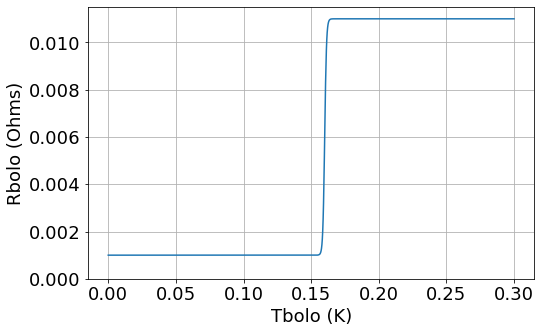

In [1]:
# Logistic function model of R(T) for a TES sensor.
# The values given lead to a Tc of 160mK, and a transition that is ~20mK wide.
# The "k" parameter controls the transition width.
# This example sets Rnormal = 10mOhms;  the appropriate value depends on the 
# kind of readout electronics you're using, with tmux and umux near this, and 
# fmux near 1 Ohm.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [8, 5]


def RofT(T):
    Rnormal = 0.010 # Ohms
    Tc = 0.16
    k = 1500
    Rbolo = Rnormal/(1+np.exp(-k*(T-Tc)))
    Rbolo = Rbolo + 0.001
    return Rbolo

T = np.linspace(0,0.3,1000)
Rbolo = RofT(T)

plt.plot(T,Rbolo)
plt.xlabel('Tbolo (K)')
plt.ylabel('Rbolo (Ohms)')
plt.ylim(0)
plt.grid()

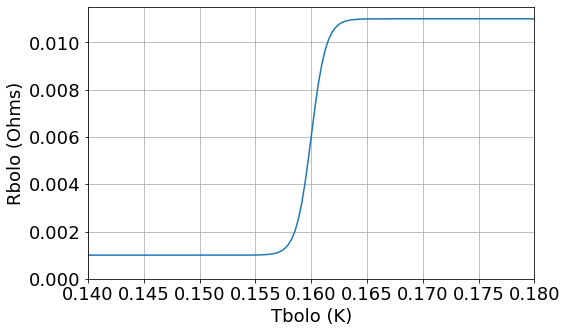

In [2]:
plt.plot(T,Rbolo)
plt.xlabel('Tbolo (K)')
plt.ylabel('Rbolo (Ohms)')
plt.ylim(0)
plt.xlim(0.14,0.18)
plt.grid()

From the R(T) curve we can see that the sensor will only work if the bolometer island is kept in a very narrow temperature range, the steeply rising part of that curve.  Naiively we might think that it will be impossible to keep the sensor stably there, but "negative electrothermal feedback" will do the trick for us.

First, let's note that we need the bolometer island to be very close to 160mK, in this example.  If the thermal bath is at a fixed temperature, we need the total power to be very close to what we call the "saturation power", $P_{sat}$, above which the island is well above $T_c$, and $R{bolo} = R_{normal}$, where the resistance will be insensitive to any changes in $P_{optical}$.

We won't go through the details here, but the value of $\bar{G}$ can be found by considering the materials and the geometry (cross section and length) making up the weak thermal link between the thermal bath and the island.  Metals, superconductors, and crystalline insulators all have thermal conductivities that go as $T^\beta$, albeit with different values of $\beta$;  integrating over the temperature gradient from one end of the thermal link to the other can be used to determine the relationship $P(T_{bolo},T_{bath})$.  The result is

$$ P_{tot} = k (T_{bolo}^n - T_{bath}^n) ,$$

where $n = \beta+1$ is expected to be 2 for legs made of normal metals, and 4 for superconductors and crystalline solids.  The value of $k$ is typically determined by the geometry of the legs;  naiively it is proportional to (CrossSectionalArea/Length).

For a given bolometer realization, we have known values of $(k,n,T_{bath})$, so we know the power $P_{tot}$ above which the bolometer will leave the transistion and no longer be sensitive.  There is no agreed-upon definition of exactly what we mean by this "saturation power" $P_{sat}$, and it is useful to simply specify it as the power required to put the bolometer right in the middle of the transition, since for a narrow transition only a little more power is required to drive it normal.

Before we proceed, let's plot $P_{tot}$ vs. $T_{bolo}$ for some example bolometers with different values of $n$.  Since we are designing to accomodate a known optical power $P_{optical}$, we'll design our different bolometers so they have the same value of $P_{sat}$, ie the power needed to get the island to $T_c$.

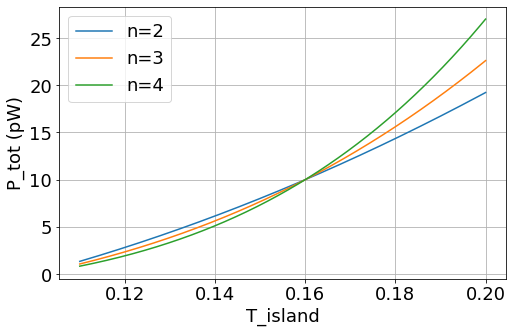

In [3]:
# Define basic parameters
Tbath = 0.1 #K
Tc = 0.16
nvec = [2,3,4]
Ptot_0 = 10e-12 #10pW is our target Psat at Tc

Tbolo = np.linspace(1.1*Tbath,2*Tbath,1000)
for n in nvec:
    # We have to set k so that it gets the right Psat for this value of n.
    # This means different leg materials require different leg geometries!
    k = Ptot_0/(Tc**n - Tbath**n)
    Ptot = k*(Tbolo**n - Tbath**n)
    labelstr = 'n='+str(n)
    plt.plot(Tbolo,Ptot*1e12,label=labelstr)
plt.legend()
plt.xlabel('T_island')
plt.ylabel('P_tot (pW)')
plt.grid()

# Biasing the detector
We start by considering a detector that has both electrical and optical power on it, indeed so much that 
$$ P_{tot} = P_{optical} + P_{electrical} \gg P_{sat} .$$
In this situation, the bolometer island temperature will be above $T_c$, and $R_{bolo} = R_{normal}.

TES bolometers are always operated with "voltage bias".  That is, we apply a constant voltage to them, making our signal be the variations in the current through them.  The power dissipated in the TES is
$$ P_{electrical} = \frac{V_{bolo}^2}{R_{bolo}} .$$

If we reduce $V_{bolo}$, $P_{electrical}$ decreases.  This reduces $P_{tot}$, and we can continue to do so until the bolometer "drops into the tranisition", with

$$ P_{electrical} + P_{optical} \approx P_{sat} $$.

Of course we can continue to reduce $V_{bolo}$ until it is zero, at which point, assuming $P_{optical} < P_{sat}$, the bolometer will be below the transition with $R_{bolo} < 0$, which is of course bad.

In the region of the transition, something unexpected happens.  There, because 
$R(T)$ is so steep, as we lower $V_{bolo}$, trying to drop further into the transition, $R_{bolo}$ decreases as well, and the quantity 
$$ P_{electrical} = \frac{V_{bolo}^2}{R_{bolo}} $$
doesn't fall as fast as we expect it to.  The steepness of $R(T)$ keeps us "stuck" in the transition longer than expected.

We are biasing the TES with a constant voltage;  therefore, if we want to monitor it for changes in its resistance we need to watch the current through it.  That is, the signal we seek is entirely encoded in the current through the sensor.

We can monitor the current as we do this process of starting out with large $V_{bolo}$ and dropping it down as it goes through the transition.  This is known as doing an "IV" curve of the bolometer, and is a useful diagnostic of the properties of the bolometer.  Let's model one given our model for P(T) and R(T).

# Simulate an IV curve
And plot some other relevant quantities.

If we apply some voltage bias to the TES, it should come into thermal equilibrium where the electrical (+optical) power input is equal to the power that leaks out the weak thermal link (the legs).  The electrical power depends on the temperature of the island through R(T).  The power going out the legs also depends on the temperature of the island.  In order to solve for the temperature of the island at a given voltage bias, we need to solve the transcendental equation, $P_{in} = P_{out}$, or

$$ P_{electrical}(T_{bolo}) + P_{optical} = k (T_{bolo}^n - T_{bath}^n) .$$

$$ \frac{V_{bolo}^2}{R(T_{bolo})} + P_{optical} = k (T_{bolo}^n - T_{bath}^n) .$$

We'll use our logistic-curve model of $R(T)$, and scipy.optimize.minimize to solve this equation for $T_{bolo}$ at any given value of $V_{bolo}$.

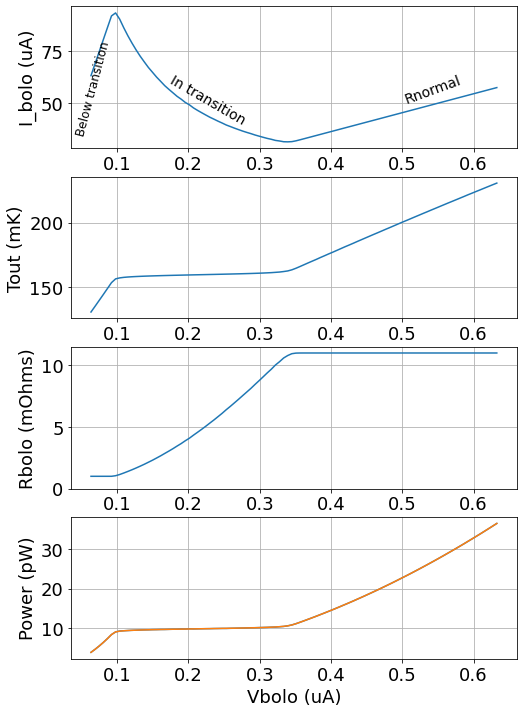

In [4]:
# Import something to do function minimization, because we can't solve analytically.
import scipy.optimize as so

# Define functions that will help us build a function that, 
# for a given voltage bias and Poptical, finds the self-consistent value of Tbolo.
#


def Pelec_of_T(V,T):
    R = RofT(T)
    P = V**2/R
    return P

def Ptot_of_T(T):
    Tbath = 0.1 #K
    Tc = 0.16
    n = 3
    Ptot_0 = 10e-12 #10pW is our target Psat at Tc
    k = Ptot_0/(Tc**n - Tbath**n)
    Ptot = k*(T**n - Tbath**n) 
    return Ptot

# This is the function we're actually going to minimize.
def min_fun(T, V, Popt):
    """ Function to minimze, at fixed V and Popt, find T that minimizes this"""
    Pe = Pelec_of_T(V,T)
    Ptot = Ptot_of_T(T)
    f = ((Ptot-Pe-Popt)*1e12)**2  # the 1e12 here converts to pW to keep f from getting too small.
    return f

# Now that we have the function to minimize, set it up and use it in a loop over 
# values of Vbias.  We have to find sensible values of Vbias of course.
# We do that knowing that our Psat is 10pW, so we start with the Vbolo that will
# get us well above the transition (40pW, say).
Popt = 0
Vbolo_start = np.sqrt(40e-12*0.01)  # start value, saturated
Vbolo_vec = np.linspace(Vbolo_start,Vbolo_start/10,100)  # work down through the transition.

Tout_vec = np.array([])  # A place to save the solutions for T at each bias
for v in Vbolo_vec:
    result = so.minimize(lambda x: min_fun(x, v, Popt), x0=0.1,method='Nelder-Mead')
    Tout_vec = np.append(Tout_vec,result.x[0])

# Now use V and T to find other relevant quantities (for plotting)
Rvec = RofT(Tout_vec)
P_elec_vec = Pelec_of_T(Vbolo_vec,Tout_vec)
Ptot_vec = Ptot_of_T(Tout_vec)
I_vec = Vbolo_vec/Rvec

# Make plots
plt.rcParams['figure.figsize'] = [8, 12]
plt.clf()
#
plt.subplot(4,1,1)
plt.plot(Vbolo_vec*1e6,I_vec*1e6)
plt.ylabel('I_bolo (uA)')
plt.text(0.5,50,'Rnormal',rotation=20,fontsize=14)
plt.text(0.17,40,'In transition',rotation=-30,fontsize=14)
plt.text(0.04,35,'Below transition',rotation=75,fontsize=12)
plt.grid()
#
plt.subplot(4,1,2)
plt.plot(Vbolo_vec*1e6,Tout_vec*1e3)
plt.ylabel('Tout (mK)')
plt.grid()
#
plt.subplot(4,1,3)
plt.plot(Vbolo_vec*1e6,Rvec*1e3)
plt.ylabel('Rbolo (mOhms)')
plt.ylim(0)
plt.grid()
#
plt.subplot(4,1,4)
plt.plot(Vbolo_vec*1e6,P_elec_vec*1e12)
plt.plot(Vbolo_vec*1e6,Ptot_vec*1e12)
plt.ylabel('Power (pW)')
plt.xlabel('Vbolo (uA)')
plt.grid()

# Plot Rbolo vs Pelec

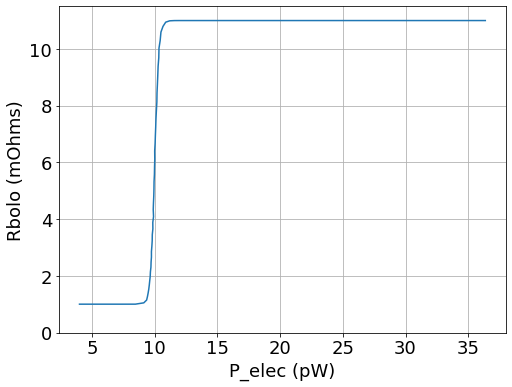

In [5]:
plt.rcParams['figure.figsize'] = [8, 6]
plt.plot(P_elec_vec*1e12, Rvec*1e3)
plt.ylabel('Rbolo (mOhms)')
plt.xlabel('P_elec (pW)')
plt.ylim(0)
plt.grid()

# Bias in the transition, then vary the optical power.
Let's do a simulation, where we start with zero optical power, and find the voltage bias that will put the TES in the middle of its transition.  As before, we'll use a model where it requires Ptot = 10pW to put it there.  To begin with, we're finding the point where this is all electrical, and finding the Voltage bias that makes that so.  Then, keeping that voltage bias constant, we'll see what happens as Poptical increases;  it turns out that the electrical power decreases to partially, but not fully, compensate for the increase in Poptical.

<ipython-input-1-70f8a8f7a5b4>:18: RuntimeWarning: overflow encountered in exp
  Rbolo = Rnormal/(1+np.exp(-k*(T-Tc)))
<ipython-input-1-70f8a8f7a5b4>:18: RuntimeWarning: overflow encountered in exp
  Rbolo = Rnormal/(1+np.exp(-k*(T-Tc)))
<ipython-input-1-70f8a8f7a5b4>:18: RuntimeWarning: overflow encountered in exp
  Rbolo = Rnormal/(1+np.exp(-k*(T-Tc)))
<ipython-input-1-70f8a8f7a5b4>:18: RuntimeWarning: overflow encountered in exp
  Rbolo = Rnormal/(1+np.exp(-k*(T-Tc)))
<ipython-input-1-70f8a8f7a5b4>:18: RuntimeWarning: overflow encountered in exp
  Rbolo = Rnormal/(1+np.exp(-k*(T-Tc)))
<ipython-input-1-70f8a8f7a5b4>:18: RuntimeWarning: overflow encountered in exp
  Rbolo = Rnormal/(1+np.exp(-k*(T-Tc)))
<ipython-input-1-70f8a8f7a5b4>:18: RuntimeWarning: overflow encountered in exp
  Rbolo = Rnormal/(1+np.exp(-k*(T-Tc)))
<ipython-input-1-70f8a8f7a5b4>:18: RuntimeWarning: overflow encountered in exp
  Rbolo = Rnormal/(1+np.exp(-k*(T-Tc)))
<ipython-input-1-70f8a8f7a5b4>:18: RuntimeWarnin

R = 0.006, T = 0.160, Vbolo = 2.387e-07


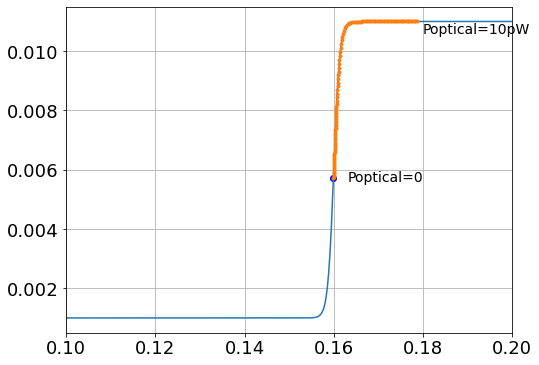

In [6]:
# We have some optical power
Popt = 0

# Start high in the transition
Vbolo_start = np.sqrt(40e-12*0.01)  # start value, saturated
result = so.minimize(lambda x: min_fun(x, Vbolo_start, Popt), x0=0.2, method='Nelder-Mead')
Tout  = result.x[0]

# Now, let's just lower V_bolo until we find ourselves at T=Tc.
Vbolo = Vbolo_start
while (Tout > 0.16):
    Vbolo = 0.95*Vbolo
    result = so.minimize(lambda x: min_fun(x, Vbolo, Popt), x0=0.18)
    Tout=result.x[0]
    R = RofT(Tout)

print('R = {0:4.3f}, T = {1:4.3f}, Vbolo = {2:4.3e}'.format(R,Tout,Vbolo))
plt.plot(Tout,R,'ob')
Popt_vec = np.linspace(0,10e-12,100)

I_vec = np.array([])
R_vec = np.array([])
T_vec = np.array([])
Pelec_vec = np.array([])
for Poptii in Popt_vec:
    result = so.minimize(lambda x: min_fun(x, Vbolo, Poptii), x0=0.3,method='Nelder-Mead')
    Tii = result.x[0]
    Rii = RofT(Tii)
    Iii = Vbolo/Rii
    Pelecii = Vbolo**2/Rii
    I_vec = np.append(I_vec,Iii)
    R_vec = np.append(R_vec,Rii)
    T_vec = np.append(T_vec,Tii)
    Pelec_vec = np.append(Pelec_vec,Pelecii)

plt.plot(T,Rbolo)
plt.plot(T_vec,R_vec,'.')
plt.xlim(0.10,0.20)
plt.text(0.163,0.0056,'Poptical=0',fontsize=14)
plt.text(0.18,0.0106,'Poptical=10pW',fontsize=14)
plt.grid()

The plot above shows how increasing the optical power slowly pushes the TES up and out of the transition.  The neat thing about this though is that it takes so much power to push it out!  What's going on?

Let's plot the values of electrical power and total (optical + electrical) power as the optical power is ramped up from zero to 12 pW, to see how those change.

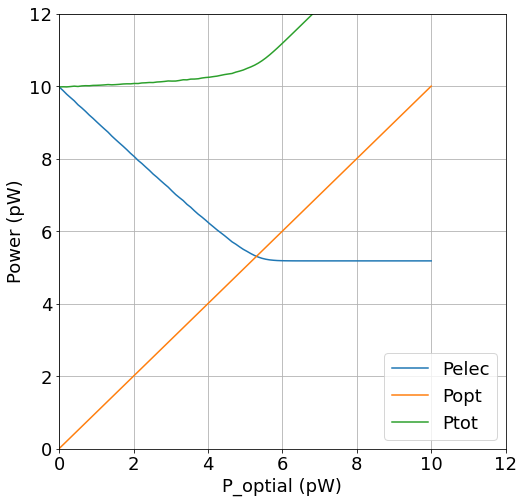

In [7]:
plt.rcParams['figure.figsize'] = [8, 8]
plt.plot(Popt_vec*1e12,Pelec_vec*1e12,label='Pelec')
plt.plot(Popt_vec*1e12,Popt_vec*1e12,label='Popt')
plt.plot(Popt_vec*1e12,(Pelec_vec+Popt_vec)*1e12,label='Ptot')
plt.xlim(0,12)
plt.ylim(0,12)
plt.xlabel('P_optial (pW)')
plt.ylabel('Power (pW)')
plt.legend()
plt.grid()

Notice that as we increase Poptical (the orange curve), the electrical power (blue curve) falls almost as fast as Poptical rises, keeping the total power (green curve) nearly constant.  At first, while the TES is in the middle, steepest part of the R(T), the total power rises only very slowly.  As the TES rises up in the transition and R(T) gets less steep, the fall in electrical power doesn't compensate as well for the increase in optical power;  the total power starts rising more quickly.  Eventually, when the TES is on the "normal" part of the R(T) curve, the electrical power becomes constant so the total just rises as the optical power rises.

# Repeat, but with some optical power

We design our bolometers so they will be in the middle of the superconducting transition, where changes in Poptical will be nearly compensated for by changes in Pelectrical, keeping Ptotal nearly constant.

So, let's refine our previous exercise by doing a similar thing, but biasing our bolometer to the middle of the transition with some optical power applied, and see what happens when that optical power rises or falls.

R = 0.006, T = 0.160, Vbolo = 1.882e-07


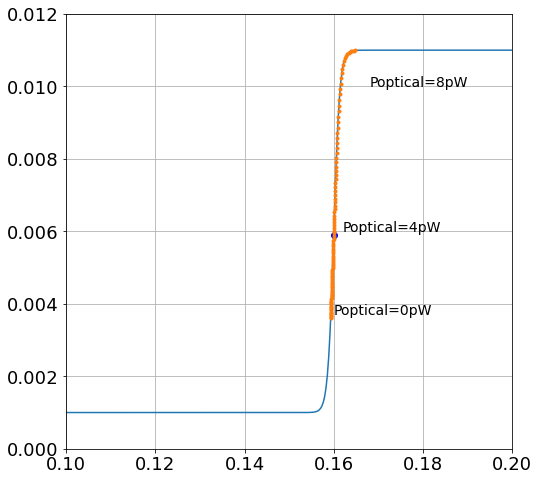

In [8]:
# We have some optical power, now!
Popt = 4e-12

# Start high in the transition
Vbolo_start = np.sqrt(40e-12*0.01)  # start value, saturated
result = so.minimize(lambda x: min_fun(x, Vbolo_start, Popt), x0=0.2)
Tout  = result.x[0]

# Now, let's just lower V_bolo until we find ourselves at T=Tc.
Vbolo=Vbolo_start
while (Tout > 0.16):
    Vbolo = 0.98*Vbolo
    result = so.minimize(lambda x: min_fun(x, Vbolo, Popt), x0=0.1)
    Tout=result.x[0]
    R = RofT(Tout)

print('R = {0:4.3f}, T = {1:4.3f}, Vbolo = {2:4.3e}'.format(R,Tout,Vbolo))
plt.plot(Tout,R,'ob')

# Set up our optical power vector
Popt_vec = np.linspace(0,8e-12,100)

# Loop over all the values of optical power, 
# finding and storing relevant quantities for each.
I_vec = np.array([])
R_vec = np.array([])
T_vec = np.array([])
Pelec_vec = np.array([])
for Poptii in Popt_vec:
    result = so.minimize(lambda x: min_fun(x, Vbolo, Poptii), x0=0.1)
    Tii = result.x[0]
    Rii = RofT(Tii)
    Iii = Vbolo/Rii
    Pelecii = Vbolo**2/Rii
    I_vec = np.append(I_vec,Iii)
    R_vec = np.append(R_vec,Rii)
    T_vec = np.append(T_vec,Tii)
    Pelec_vec = np.append(Pelec_vec,Pelecii)

#plot everything.
plt.plot(T,Rbolo)
plt.plot(T_vec,R_vec,'.')
plt.xlim(0.10,0.20)
plt.ylim(0,0.012)
plt.text(0.162,0.006,'Poptical=4pW',fontsize=14)
plt.text(0.16,0.0037,'Poptical=0pW',fontsize=14)
plt.text(0.168,0.010,'Poptical=8pW',fontsize=14)
plt.grid()

# Current responsivity:  dI/dP_optical
Now, let's plot the current through the bolometer (which is what we measure) as a function of Poptical, around the neighborhood of our baseline power (4pW).  

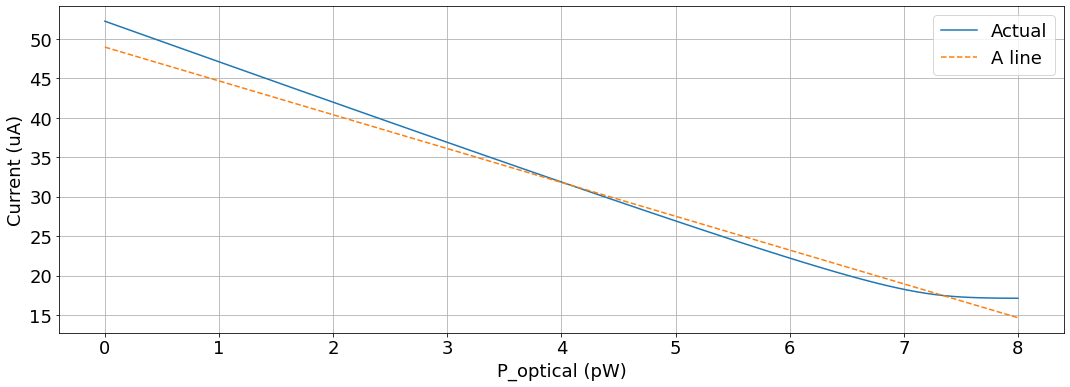

In [9]:
xlinear = np.linspace(0,8,10)
ylinear = 31.8 - (30/7)*(xlinear-4)
plt.rcParams['figure.figsize'] = [18, 6]
plt.plot(Popt_vec*1e12,I_vec*1e6,label='Actual')
plt.plot(xlinear,ylinear,'--',label='A line')
plt.plot()
plt.xlabel('P_optical (pW)')
plt.ylabel('Current (uA)')
plt.legend()
plt.grid()

This plot shows us that the change in current is nearly, but not perfectly, a linear function of the optical power.   The current responsivity, dI/dP, is the derivative of this curve.

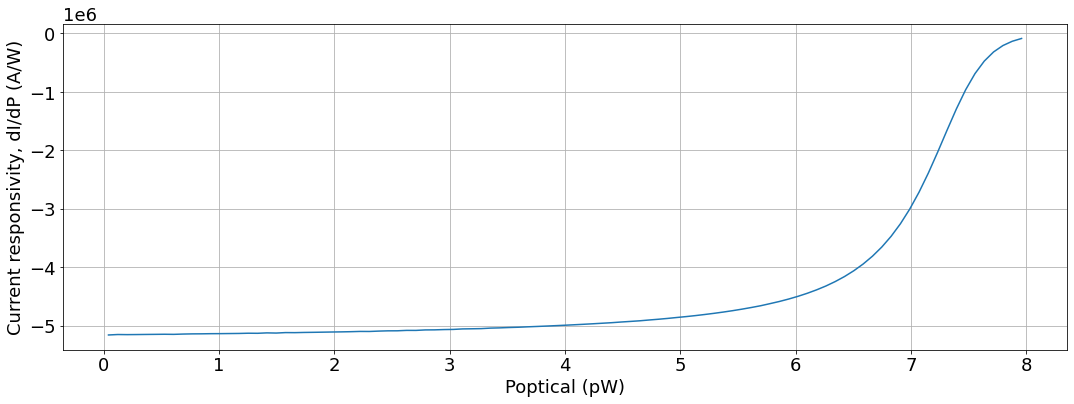

In [10]:
# Find dI/dP and plot it
dP = (Popt_vec[1:]-Popt_vec[:-1])
Popt_avg = (Popt_vec[1:]+Popt_vec[:-1])/2  #this gives us a P vector to plot against with the same number of elements as dIdP
dI = (I_vec[1:]-I_vec[:-1])
dIdP = dI/dP # Amps/Watt
plt.plot(Popt_avg*1e12, dIdP,label='Actual')
plt.xlabel('Poptical (pW)')
plt.ylabel('Current responsivity, dI/dP (A/W)')
plt.grid()

Notice that the responsivity is not constant;  it varies as the bolometer moves around in the transition.  The responsivity in this model, for this particular shape of R(T), changes more as optical power is added than subtracted.

# Loop gain
The effects we've seen above - the electrical power changing opposite the optical power, leading to a fairly constant responsivity (for small changes in optical power), can be characterized (for a small region around the bias point) by writing down equations for "Electrothermal feedback" locally at a given point in the transition.

A general system with feedback is shown below. 

<img src="BoloIntro/Block_diagram_for_feedback.png"  width="500"/>

Our "input" is a change in optical power.  The feedback mechanism is the change in electrical power, which sums with the optical power to form the total power.  The "loop gain" $\cal{L}$ is the product of $A_{OL}$ and $\beta$ in the diagram above.  

We can write out some simple math in order to quantify the loop gain.  Let's begin by considering a small variation in power away from a quiescent value $P_0$,

$$   P_{tot} = P_0 + G_{dyn} \Delta T $$

where $T$ is the sensor temperature and $G_{dyn}$ is the dynamic thermal conductance, $G_{dyn} \equiv dP_{tot}/dT$.
For small changes around the quiescent value of the TES resistance, 
the resistance is given by
 
$$  R(T) = R_0 + \frac{dR}{dT} \Delta T  . $$
Defining

$$  \alpha \equiv \frac{d \log R}{d \log T} = \frac{T_0}{R_0} \frac{dR}{dT}, $$

this becomes

$$  R(T) = R_0 + \alpha \frac{R_0}{T_0} \Delta T . $$

Using these, we can write the Joule heating power in the constant-voltage biased TES as

$$ P_J = P_{J_0} + \Delta P_J $$

$$ P_J = \frac{V_0^2}{R_0} + \frac{dP_J}{dR} \frac{dR}{dT} \Delta T $$

$$   = P_{J_0}   -  \frac{V_0^2}{R_0^2}  \alpha \frac{R_0}{T_0} \Delta T $$

$$  = P_{J_0}   - \alpha \frac{V_0^2}{R_0 T_0}  \Delta T $$

$$  = P_{J_0} \left( 1  - \frac{\alpha \Delta T}{ T_0}  \right), $$

from which we can see that

$$ \Delta P_J  = - \frac{P_{J_0} \alpha \Delta T}{ T_0} \tag{1} , $$

which we will use soon.

We can also write down a relationship between $\Delta P_{ext}$ and $\Delta P_J$   in terms of the loop gain ${\cal L}$, which is a term borrowed from negative feedback systems in electronics (as in the figure above).  The point is that high loop gain leads to a near balanced set of inputs to the differencing node;  in the TES bolometer case we deal with powers rather than voltages, and the inputs are the changes in external power and electrical power, the sum of which (noting that changes in the electrical power are opposite the external power change, ie they accrue a negative sign in the ``loop") is the total power.  Thus, the loop gain is the ratio of the change in electrical power to the change in total power,

$$  {\cal L} \equiv \frac{-\Delta P_J}{\Delta P_{tot}} =  \frac{-\Delta P_J}{\Delta P_{J} + \Delta P_{ext}}, \tag{2}$$

where in our system $P_{ext} = P_{optical}$.
Note that ideally $\Delta P_J \sim - \Delta P_{ext}$, so the denominator approaches zero and the loop gain is large.  The loop gain becomes unity when $|\Delta P_J| = |\Delta P_{ext}|/2$.  


We can express the ratio of the changes in Joule and external heating powers in terms of the loop gain by rearranging Eq. 2, 

$$ \frac{\Delta P_J}{\Delta P_{ext}} = \frac{{- \cal L}}{{\cal L}+1} . $$

Using $\Delta P_{tot} = G_{dyn} \Delta T$, we find

$$   {\cal L} = \frac{-\Delta P_J}{G_{dyn} \Delta T}, $$

and combining with Eq. 1, we arrive at 


$$ {\cal L} = \frac{P_{J_0} \alpha}{G_{dyn} T_0} . $$


This last equation allows us to design and bolometer and calculate the loop gain from these general input parameters.  Note that in our model, taking the derivative of 

$$ P_{tot} = k (T_{bolo}^n - T_{bath}^n) $$

yields

$$ G_{dyn} = n k T_{bolo}^{(n-1)} .$$

In practice, for noise considerations 
we design a bolometer with $P_{J_0} = A P_{optical}$, where A is between 1 and 2, 
and $P_{sat} = (1+A)P_{optical}$.  We know $T_0 = T_c$, and $G_{dyn}$ is determined by $P_{sat}$ and $n$.  Finally, and importantly, the loop gain is proportional to $\alpha$, related to the steepness of R(T) 

High loop gain is good because it means the change in electrical power almost completely cancels a change in electrical power, and the bolometer stays close to 
one point in the transition.  As we'll see later, though, it also speeds up the
bolometer response, which can cause problems.

Let's now calculate $\alpha$ and ${\cal L}$ for our model transition.

(0.14, 0.17)

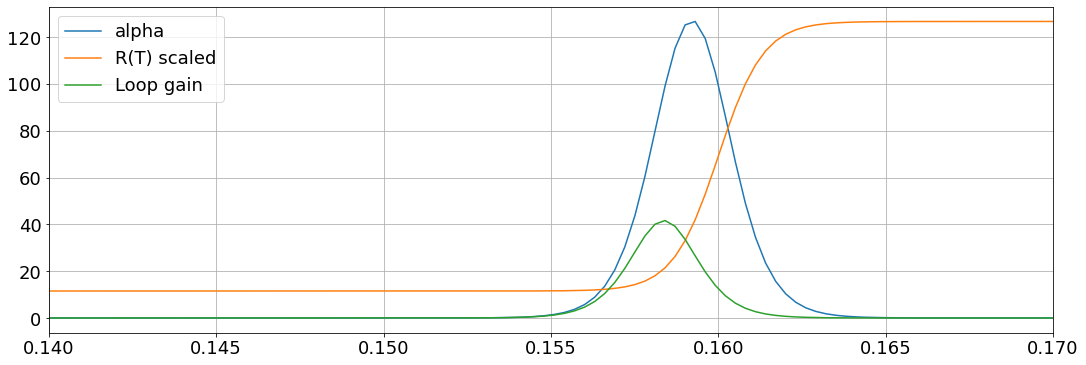

In [11]:
dT = T[1]-T[0]
Tnew = (T[1:] + T[:-1])/2
Rnew = (Rbolo[1:] + Rbolo[:-1])/2
dR = Rbolo[1:]-Rbolo[:-1]
dRdT = dR/dT
alpha = (Tnew/Rnew)*dR/dT

Pelec = Vbolo**2/Rnew

k = Ptot_0/(Tc**n - Tbath**n)
Gdyn = n*k*Tnew**(n-1)

L = Pelec*alpha/(Gdyn*Tnew)

plt.plot(Tnew,alpha,label='alpha')
plt.plot(Tnew,Rnew*np.max(alpha)/np.max(Rnew),label='R(T) scaled')
plt.plot(Tnew,L,label='Loop gain')
plt.legend()
plt.grid()
plt.xlim(0.14,0.17)

This shows an interesting feature of our transition;  alpha